In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import time
from matplotlib.animation import FuncAnimation

In [2]:
try_number = 0
path = 'Backward/'

In [3]:
T = 0.1
field_size = 200
time_duration = 100

t = T / time_duration
h = 1 / (field_size - 1)
u = np.zeros((field_size, field_size, time_duration))

In [4]:
def phi(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def g(x, y, t):
    return 0

In [5]:
def generate_A(n, h, t):
    A = np.eye((n * n), dtype='float')
    for i in range(1, n - 1):
        for j in range(1, n - 1):
            row = n * j + i
            A[row][n * j + i] = h ** 2 + 4 * t
            A[row][n * j + (i - 1)] = -t
            A[row][n * j + (i + 1)] = -t
            A[row][n * (j - 1) + i] = -t
            A[row][n * (j + 1) + i] = -t
    return A
            

def generate_b(u, n, h, t, k):
    b = np.zeros((n, n))
    
    boundary_mask = np.zeros((n, n), dtype=bool)
    boundary_mask[0, :] = boundary_mask[-1, :] = True
    boundary_mask[:, 0] = boundary_mask[:, -1] = True
    
    inner_mask = ~boundary_mask
    i, j = np.where(boundary_mask)
    b[boundary_mask] = g(i * h, j * h, k * t)
    
    b[inner_mask] = h ** 2 * u[inner_mask][:, k]
    b = b.ravel()
    
    return b

In [6]:
A = csr_matrix(generate_A(field_size, h, t))

In [7]:
def Solution():
    for i in range(field_size):
        for j in range(field_size):
            if i == 0 or j == 0 or i == field_size - 1 or j == field_size - 1:
                u[i][j][0] = g(i * h, j * h, 0)
            else:
                u[i][j][0] = phi(i * h, j * h)
    
    A = csr_matrix(generate_A(field_size, h, t))
    for k in range(1, time_duration):
        b = generate_b(u, field_size, h, t, k - 1)
        y = spsolve(A, b)
        u[:, :, k] = y.reshape(field_size, field_size)

In [8]:
Solution()

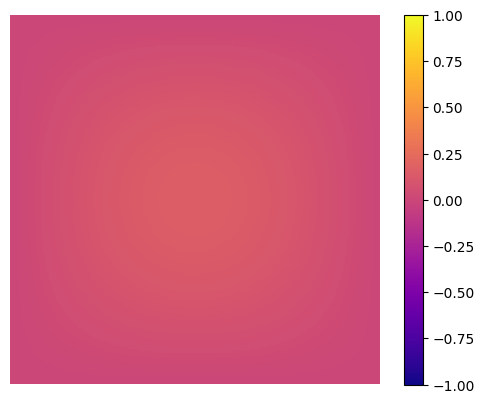

In [9]:
fig, ax = plt.subplots()
frames = time_duration - 3
interval = 100
heatmap = ax.imshow(u[:, :, 0], cmap='plasma', interpolation='nearest', vmin = -1, vmax = 1)

def update(frame):
    heatmap.set_array(u[:, :, frame - 1])
    return [heatmap]

plt.colorbar(heatmap)
plt.axis('off')
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(path + f'Method animation{try_number}.gif', writer=PillowWriter(fps=10))

In [10]:
u_solve = np.zeros_like(u)
R = np.zeros_like(u)

def solve(x, y, t):
    return np.exp(-2 * np.pi ** 2 * t) * np.sin(np.pi * x) * np.sin(np.pi * y)

In [11]:
def create_u_solve_and_R():
    global max_R
    global time_R
    for k in range(time_duration):
        for i in range(field_size):
            for j in range(field_size):
                u_solve[i, j, k] = solve(i * h, j * h, k * t)
                R[i, j, k] = abs(u_solve[i, j, k] - u[i, j, k])
                if R[i, j, k] > max_R:
                    max_R = R[i, j, k]
                    time_R = k
                    

In [ ]:
max_R = 0.0
time_R = 0.0
create_u_solve_and_R()

In [ ]:
fig, ax = plt.subplots()
frames = time_duration - 3
interval = 100
heatmap = ax.imshow(u[:, :, 0], cmap='plasma', interpolation='nearest', vmin = -1, vmax = 1)

def update(frame):
    heatmap.set_array(u_solve[:, :, frame - 1])
    return [heatmap]

plt.colorbar(heatmap)
plt.axis('off')
ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
ani.save(path + f'solve animation{try_number}.gif', writer=PillowWriter(fps=10))

In [ ]:
print(f'Максимальная погрешность равна {max_R} на итерации {time_R}')

In [ ]:
x = np.arange(field_size)
y = np.arange(field_size)
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(0, 5)

# Начальное значение поверхности
z = R[:, :, 0]
surf = ax.plot_surface(x, y, z, cmap='viridis')

def update(frame):
    ax.clear()
    ax.set_zlim(0, 0.01)
    z = R[:, :, frame]
    surf = ax.plot_surface(x, y, z, cmap='viridis')
    return surf,

ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save(path + f'Error animation{try_number}.gif', writer='imagemagick', fps=15)
plt.show()
